In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb

In [2]:
# dataset used
# replace with Zach's df
df2 = pd.read_csv("0.05percent_2classes_processed.csv")
df8 = pd.read_csv("0.05percent_8classes_processed.csv")
df34 = pd.read_csv("0.05percent_34classes_processed.csv")

In [3]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

# Processing and Splitting our dataset Function
80% Train 20% Test

In [5]:
# Let's try sampling 400k datapoints

def split(df_name):
    if df_name == "df2":
        label = "benign"
        df = df2.sample(n=400000, random_state=42)
    else:
        label = "label"
        if df_name == "df8": df = df8.sample(n=400000, random_state=42)
        else: df = df34.sample(n=400000, random_state=42)

    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]

    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)

    # encoding for XGBoost
    encoder = LabelEncoder()
    encoded_y_train = encoder.fit_transform(y_train)
    encoded_y_test = encoder.fit_transform(y_test)

    return scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test

# Evaluation Functions

In [6]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, y_test, target_names, classes, model_name):
    pred = model.predict(scaled_X_test)

    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])

    if model_name == "XGBoost":
        print(classification_report(y_test, pred, target_names = target_names, digits = 3))

        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);
    else:
        print(classification_report(y_test, pred, digits = 3))

        if classes == 2 or classes == 8:
            plt.figure(figsize = (4, 2), dpi = 300)
            ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2),
                                   display_labels = target_names).plot()
            plt.xticks(rotation=90);

In [7]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [8]:
# inspired from Zach
def get_weights(y_train):
    import math

    # Get counts in log10
    y_train_count = y_train.value_counts()
    y_log = y_train_count.apply(lambda x: math.log10(x))

    # Find the factor needed to bring minority classes to majority
    y_log_max = y_log.max()
    y_log = y_log.apply(lambda x: math.pow(10,y_log_max - x))

    weight_dict = y_log.to_dict()

    return weight_dict

# Save models


In [9]:
# Add this function to your notebook to create directories and save models
import os
import pickle

def save_model(model, model_name, class_type):
    """
    Save a trained model to disk based on classification type
    
    Parameters:
    -----------
    model : trained model object
        The trained model to save
    model_name : str
        Name of the model (e.g., 'Logistic Regression', 'Random Forest')
    class_type : int
        Classification type (2, 8, or 34)
    """
    # Create directory structure if it doesn't exist
    base_dir = f"saved_models/class_{class_type}"
    os.makedirs(base_dir, exist_ok=True)
    
    # Create file name with no spaces
    file_name = model_name.replace(" ", "_").lower()
    file_path = f"{base_dir}/{file_name}.pkl"
    
    # Save the model using pickle
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model '{model_name}' saved for {class_type}-class classification at: {file_path}")

# Function to save the scaler object as well (important for preprocessing new data)
def save_scaler(scaler, class_type):
    """
    Save the fitted StandardScaler object
    
    Parameters:
    -----------
    scaler : StandardScaler
        The fitted scaler object
    class_type : int
        Classification type (2, 8, or 34)
    """
    base_dir = f"saved_models/class_{class_type}"
    os.makedirs(base_dir, exist_ok=True)
    
    file_path = f"{base_dir}/standard_scaler.pkl"
    
    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)
    
    print(f"Scaler saved for {class_type}-class classification at: {file_path}")

# Function to load a saved model
def load_model(model_name, class_type):
    """
    Load a saved model from disk
    
    Parameters:
    -----------
    model_name : str
        Name of the model (e.g., 'Logistic Regression', 'Random Forest')
    class_type : int
        Classification type (2, 8, or 34)
        
    Returns:
    --------
    model : trained model object
        The loaded model
    """
    file_name = model_name.replace(" ", "_").lower()
    file_path = f"saved_models/class_{class_type}/{file_name}.pkl"
    
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
    
    return model

# Function to load a saved scaler
def load_scaler(class_type):
    """
    Load a saved scaler from disk
    
    Parameters:
    -----------
    class_type : int
        Classification type (2, 8, or 34)
        
    Returns:
    --------
    scaler : StandardScaler
        The loaded scaler object
    """
    file_path = f"saved_models/class_{class_type}/standard_scaler.pkl"
    
    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)
    
    return scaler

# Example of how to save models after training
# For 2-class classification models
def save_models_for_class_2():
    # Save the scaler first
    # Make sure to get the scaler that was used to transform the training data
    save_scaler(scaler, 2)
    
    # Save all models
    save_model(logreg_model, "Logistic Regression", 2)
    save_model(clf, "Adaboost", 2)
    save_model(gbc, "Gradientboost", 2)
    save_model(knn, "KNN", 2)
    save_model(svc, "BSVM", 2)  # For the balanced SVM
    save_model(svc, "WSVM", 2)  # For the weighted SVM (make sure to rename variable before saving)
    save_model(xgc, "XGBoost", 2)
    save_model(rfc, "Random Forest", 2)
    save_model(rfc, "Random Forest Weight", 2)  # Make sure to rename variable
    save_model(rfc, "Random Forest Bagging", 2)  # Make sure to rename variable

# Similar functions for 8-class and 34-class models
def save_models_for_class_8():
    save_scaler(scaler, 8)
    # Save all the 8-class models using the same pattern as above
    
def save_models_for_class_34():
    save_scaler(scaler, 34)
    # Save all the 34-class models using the same pattern as above

# Example of how to load and use a saved model for prediction
def load_and_predict(model_name, class_type, X_new):
    """
    Load a model and scaler, and make predictions on new data
    
    Parameters:
    -----------
    model_name : str
        Name of the model to load
    class_type : int
        Classification type (2, 8, or 34)
    X_new : array-like
        New data to predict on
    
    Returns:
    --------
    predictions : array
        Predicted classes
    """
    # Load model and scaler
    model = load_model(model_name, class_type)
    scaler = load_scaler(class_type)
    
    # Scale the new data
    X_new_scaled = scaler.transform(X_new)
    
    # Make predictions
    predictions = model.predict(X_new_scaled)
    
    return predictions

# 2 Classes

In [10]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df2")

In [11]:
weight_dict = get_weights(y_train)
weight_dict

{False: 1.0, True: 41.6552919221541}

In [11]:
# essential for XGBoost
target_names = ["Attack", "Benign"]

## Logistic Regression

              precision    recall  f1-score   support

       False      0.993     0.994     0.994     78124
        True      0.750     0.693     0.720      1876

    accuracy                          0.987     80000
   macro avg      0.871     0.844     0.857     80000
weighted avg      0.987     0.987     0.987     80000

Model 'Logistic Regression' saved for 2-class classification at: saved_models/class_2/logistic_regression.pkl


<Figure size 1200x600 with 0 Axes>

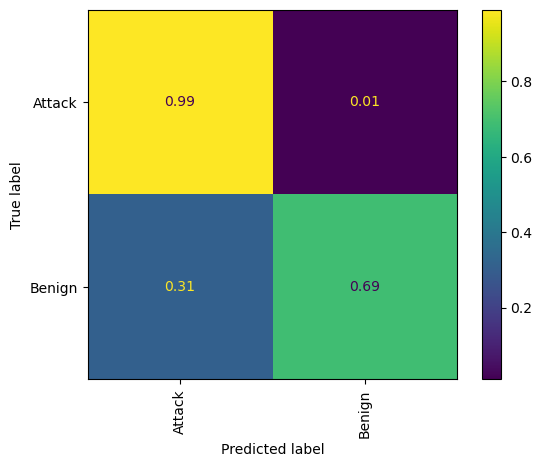

In [12]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 2, "Logistic Regression")
save_model(logreg_model, "Logistic Regression", 2)



# Adaboost

              precision    recall  f1-score   support

       False      0.986     0.994     0.990     78124
        True      0.646     0.421     0.510      1876

    accuracy                          0.981     80000
   macro avg      0.816     0.708     0.750     80000
weighted avg      0.978     0.981     0.979     80000

Model 'Adaboost' saved for 2-class classification at: saved_models/class_2/adaboost.pkl


<Figure size 1200x600 with 0 Axes>

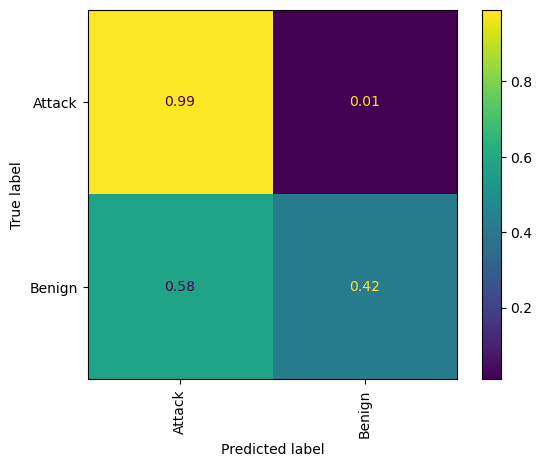

In [13]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 2, "Adaboost")
save_model(clf, "Adaboost", 2)

# Gradientboost

              precision    recall  f1-score   support

       False      0.985     0.995     0.990     78124
        True      0.639     0.370     0.469      1876

    accuracy                          0.980     80000
   macro avg      0.812     0.682     0.729     80000
weighted avg      0.977     0.980     0.978     80000

Model 'Gradientboost' saved for 2-class classification at: saved_models/class_2/gradientboost.pkl


<Figure size 1200x600 with 0 Axes>

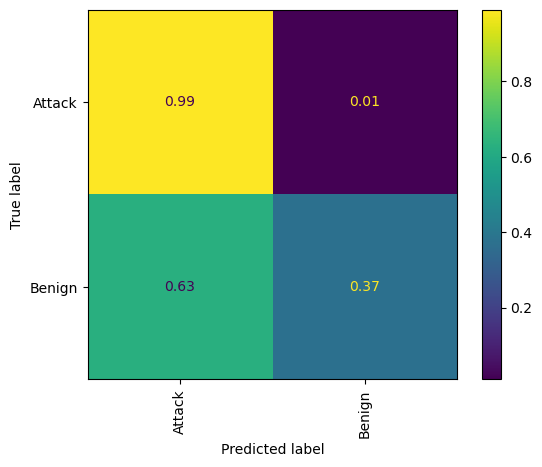

In [14]:
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 2, "Gradientboost")
save_model(gbc, "Gradientboost", 2)

# KNN

              precision    recall  f1-score   support

       False      0.996     0.994     0.995     78124
        True      0.785     0.841     0.812      1876

    accuracy                          0.991     80000
   macro avg      0.891     0.918     0.904     80000
weighted avg      0.991     0.991     0.991     80000

Model 'KNN' saved for 2-class classification at: saved_models/class_2/knn.pkl


<Figure size 1200x600 with 0 Axes>

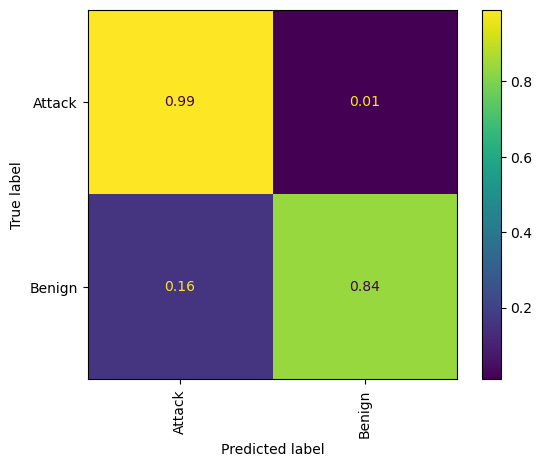

In [15]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 2, "KNN")

save_model(knn, "KNN", 2)

## Balanced SVM

              precision    recall  f1-score   support

       False      1.000     0.987     0.994     78124
        True      0.651     0.996     0.787      1876

    accuracy                          0.987     80000
   macro avg      0.825     0.992     0.890     80000
weighted avg      0.992     0.987     0.989     80000

Model 'BSVM' saved for 2-class classification at: saved_models/class_2/bsvm.pkl


<Figure size 1200x600 with 0 Axes>

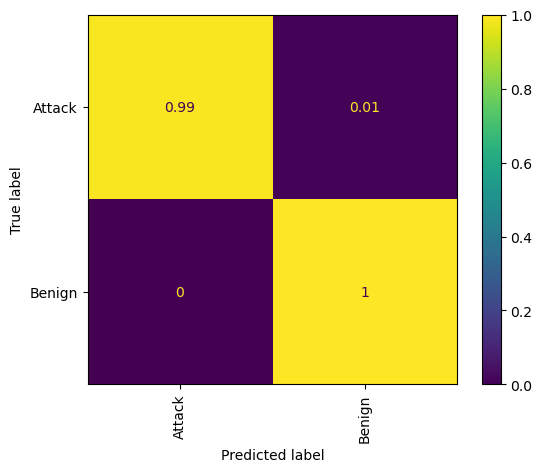

In [16]:
# Balanced Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = "balanced", gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 2, "BSVM")

save_model(svc, "BSVM", 2)

## Weighted SVM

              precision    recall  f1-score   support

       False      1.000     0.988     0.994     78124
        True      0.663     0.991     0.794      1876

    accuracy                          0.988     80000
   macro avg      0.831     0.989     0.894     80000
weighted avg      0.992     0.988     0.989     80000

Model 'WSVM' saved for 2-class classification at: saved_models/class_2/wsvm.pkl


<Figure size 1200x600 with 0 Axes>

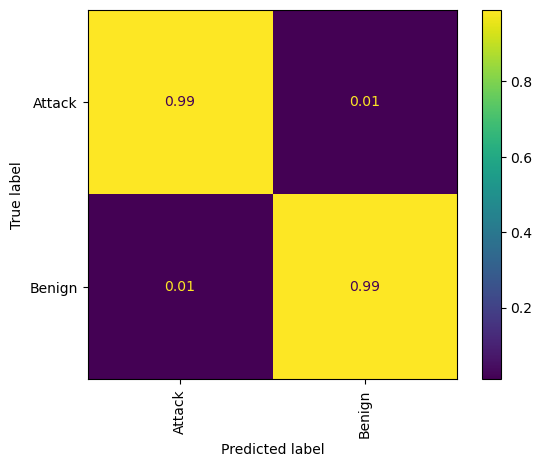

In [17]:
# Weighted Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = weight_dict, gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 2, "WSVM")
save_model(svc, "WSVM", 2)

# XGBoost

              precision    recall  f1-score   support

      Attack      0.997     0.997     0.997     78124
      Benign      0.855     0.858     0.857      1876

    accuracy                          0.993     80000
   macro avg      0.926     0.927     0.927     80000
weighted avg      0.993     0.993     0.993     80000

Model 'XGBoost' saved for 2-class classification at: saved_models/class_2/xgboost.pkl


<Figure size 1200x600 with 0 Axes>

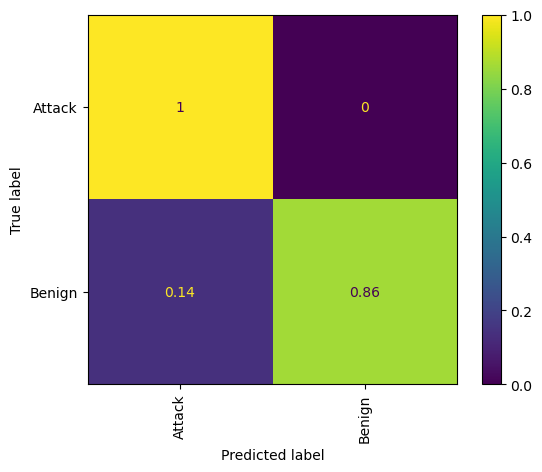

In [20]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13,n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 2, "XGBoost")

save_model(xgc, "XGBoost", 2)

# Random Forest

              precision    recall  f1-score   support

       False      0.986     0.996     0.991     78124
        True      0.729     0.425     0.537      1876

    accuracy                          0.983     80000
   macro avg      0.858     0.711     0.764     80000
weighted avg      0.980     0.983     0.981     80000

Model 'Random Forest' saved for 2-class classification at: saved_models/class_2/random_forest.pkl


<Figure size 1200x600 with 0 Axes>

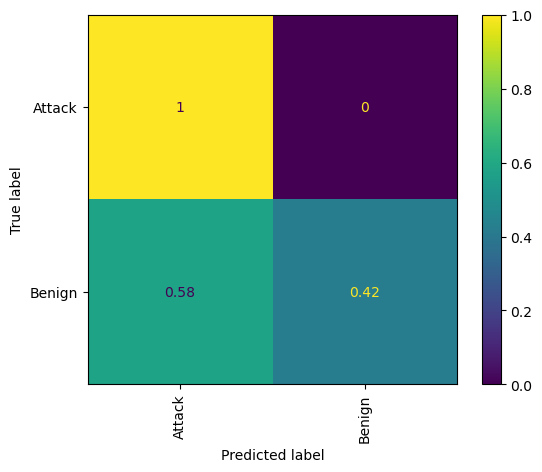

In [21]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest")
save_model(rfc, "Random Forest", 2)

              precision    recall  f1-score   support

       False      0.977     0.998     0.988     78124
        True      0.358     0.039     0.070      1876

    accuracy                          0.976     80000
   macro avg      0.668     0.519     0.529     80000
weighted avg      0.963     0.976     0.966     80000

Model 'Random Forest - Weight' saved for 2-class classification at: saved_models/class_2/random_forest_-_weight.pkl


<Figure size 1200x600 with 0 Axes>

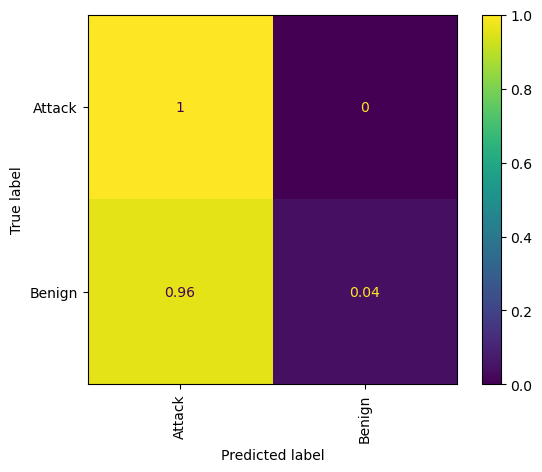

In [27]:
# Weight-balanced
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest - Weight")
save_model(rfc, "Random Forest - Weight", 2)

/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

              precision    recall  f1-score   support

       False      1.000     0.986     0.993     78124
        True      0.632     0.994     0.773      1876

    accuracy                          0.986     80000
   macro avg      0.816     0.990     0.883     80000
weighted avg      0.991     0.986     0.988     80000

Model 'Random Forest - Bagging' saved for 2-class classification at: saved_models/class_2/random_forest_-_bagging.pkl


<Figure size 1200x600 with 0 Axes>

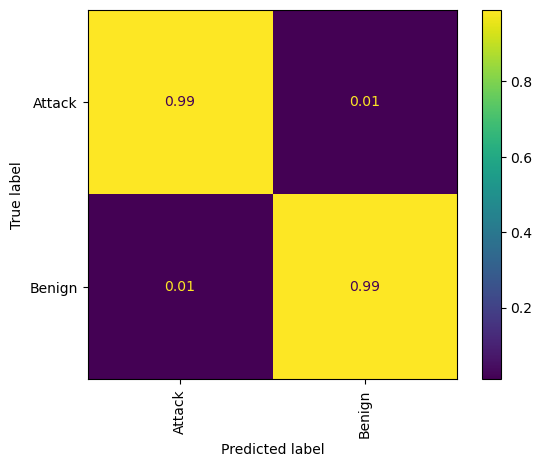

In [28]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 2, "Random Forest - Bagging")
save_model(rfc, "Random Forest - Bagging", 2)

In [29]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv('metrics_2.csv', index=True)
metrics_2
# Add:

,Logistic Regression,Adaboost,Gradientboost,KNN,BSVM,WSVM,XGBoost,Random Forest,Random Forest - Weight,Random Forest - Bagging
Accuracy,0.987375,0.981025,0.980325,0.990875,0.987387,0.987975,0.993263,0.982812,0.975825,0.986275
Recall,0.843704,0.70779,0.682459,0.917811,0.991721,0.989421,0.927097,0.710526,0.518618,0.990111
Precision,0.871176,0.816348,0.812032,0.890627,0.825451,0.831381,0.925989,0.857756,0.667624,0.815816
F1-Score,0.856882,0.750166,0.72929,0.903735,0.890473,0.894125,0.926542,0.764062,0.528973,0.88275


# 8 Classes

In [12]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df8")

In [13]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS': 1.0,
 'DoS': 4.217345664488805,
 'Mirai': 12.836500853853368,
 'Benign': 31.061183684350862,
 'Spoofing': 68.8392909896603,
 'Recon': 95.61797291752158,
 'Web': 1429.5766871165652,
 'BruteForce': 2709.5465116279092}

In [14]:
y_test.value_counts()

label
DDoS          58255
DoS           13813
Mirai          4538
Benign         1876
Spoofing        846
Recon           609
Web              41
BruteForce       22
Name: count, dtype: int64

In [15]:
# essential for XGBoost
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

## Logistic Regression

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

      Benign      0.689     0.876     0.771      1876
  BruteForce      1.000     0.091     0.167        22
        DDoS      0.823     0.991     0.899     58255
         DoS      0.696     0.110     0.190     13813
       Mirai      0.986     0.993     0.989      4538
       Recon      0.544     0.297     0.384       609
    Spoofing      0.753     0.345     0.473       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.824     80000
   macro avg      0.686     0.463     0.484     80000
weighted avg      0.804     0.824     0.770     80000

Model 'Logistic Regression' saved for 8-class classification at: saved_models/class_8/logistic_regression.pkl


<Figure size 1200x600 with 0 Axes>

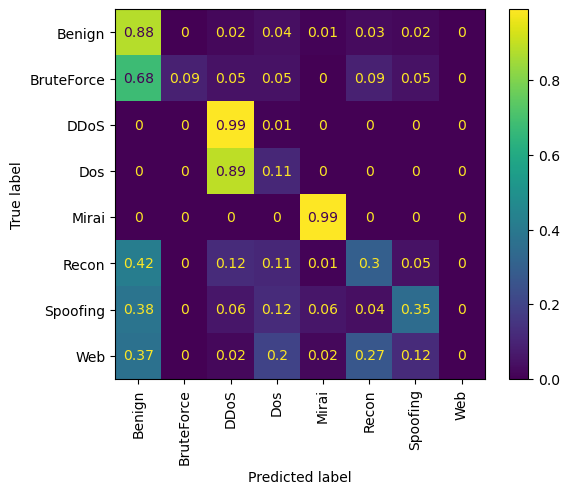

In [34]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42,n_jobs=-1)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 8, "Logistic Regression")
save_model(logreg_model, "Logistic Regression", 8)

## Adaboost

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

      Benign      0.733     0.887     0.803      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.979     0.467     0.633     58255
         DoS      0.307     0.995     0.470     13813
       Mirai      0.998     0.876     0.933      4538
       Recon      0.524     0.425     0.470       609
    Spoofing      0.734     0.641     0.684       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.592     80000
   macro avg      0.535     0.536     0.499     80000
weighted avg      0.851     0.592     0.624     80000

Model 'Adaboost' saved for 8-class classification at: saved_models/class_8/adaboost.pkl


<Figure size 1200x600 with 0 Axes>

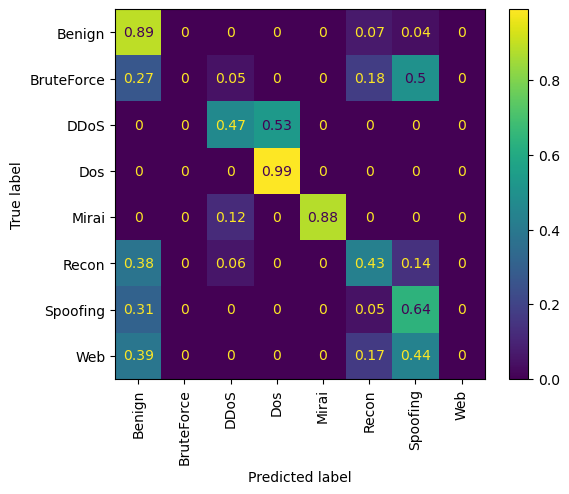

In [35]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42)
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 8, "Adaboost")
save_model(clf, "Adaboost", 8)

## Gradientboost

              precision    recall  f1-score   support

      Benign      0.760     0.215     0.335      1876
  BruteForce      0.002     0.091     0.004        22
        DDoS      0.977     0.467     0.632     58255
         DoS      0.308     0.999     0.471     13813
       Mirai      0.930     0.887     0.908      4538
       Recon      0.424     0.187     0.260       609
    Spoofing      0.570     0.832     0.676       846
         Web      0.255     0.317     0.283        41

    accuracy                          0.579     80000
   macro avg      0.528     0.499     0.446     80000
weighted avg      0.845     0.579     0.610     80000

Model 'Gradientboost' saved for 8-class classification at: saved_models/class_8/gradientboost.pkl


<Figure size 1200x600 with 0 Axes>

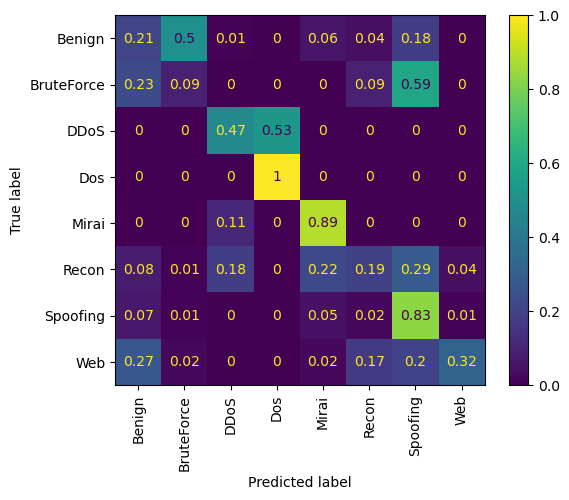

In [37]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)


evaluate(gbc, y_test, target_names, 8, "Gradientboost")

save_model(gbc, "Gradientboost", 8)

# KNN

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

      Benign      0.724     0.944     0.819      1876
  BruteForce      1.000     0.091     0.167        22
        DDoS      0.946     0.698     0.803     58255
         DoS      0.396     0.833     0.537     13813
       Mirai      0.996     0.994     0.995      4538
       Recon      0.731     0.514     0.604       609
    Spoofing      0.805     0.482     0.603       846
         Web      0.000     0.000     0.000        41

    accuracy                          0.740     80000
   macro avg      0.700     0.570     0.566     80000
weighted avg      0.845     0.740     0.764     80000

Model 'KNN' saved for 8-class classification at: saved_models/class_8/knn.pkl


<Figure size 1200x600 with 0 Axes>

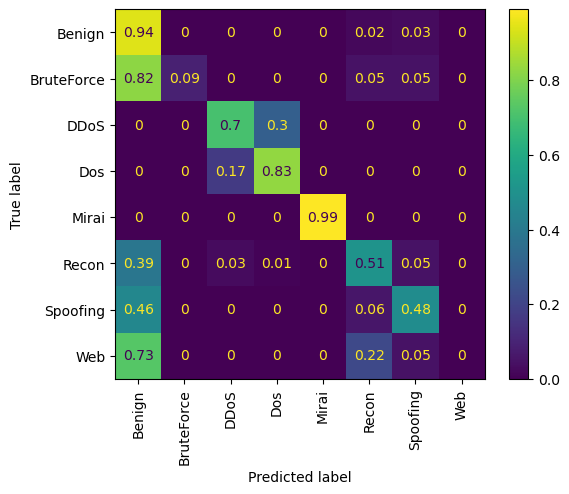

In [38]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 8, "KNN")

save_model(knn, "KNN", 8)

## Balanced SVM

In [ ]:
# Balanced Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = "balanced", gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 8, "BSVM")
save_model(svc, "BSVM", 8)

# Weighted SVM

In [ ]:
# Weighted Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = weight_dict, gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 8, "WSVM")
save_model(svc, "WSVM", 8)

## XGBoost

/home/faissalm/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:11:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_samples" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

      Benign      0.781     0.450     0.571      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.821     0.988     0.897     58255
         Dos      0.965     0.095     0.173     13813
       Mirai      0.875     0.999     0.933      4538
       Recon      0.525     0.529     0.527       609
    Spoofing      0.377     0.716     0.494       846
         Web      0.161     0.122     0.139        41

    accuracy                          0.815     80000
   macro avg      0.563     0.487     0.467     80000
weighted avg      0.840     0.815     0.758     80000

Model 'XGBoost' saved for 8-class classification at: saved_models/class_8/xgboost.pkl


<Figure size 1200x600 with 0 Axes>

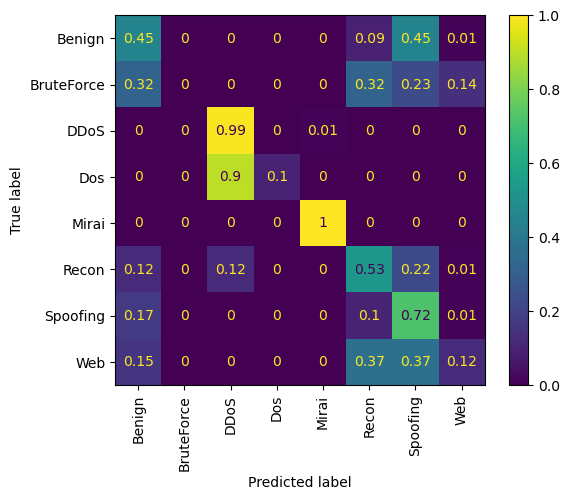

In [16]:
# Required to be trained on scaled_X_train, encoded_y_train
# evaluate parameter for y_test to be encoded y_test
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9 ,n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 8, "XGBoost")
save_model(xgc, "XGBoost", 8)

## Random Forest

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

      Benign      0.807     0.475     0.598      1876
  BruteForce      0.000     0.000     0.000        22
        DDoS      0.820     1.000     0.901     58255
         DoS      0.994     0.076     0.141     13813
       Mirai      0.999     0.999     0.999      4538
       Recon      0.636     0.494     0.556       609
    Spoofing      0.369     0.784     0.502       846
         Web      1.000     0.073     0.136        41

    accuracy                          0.821     80000
   macro avg      0.703     0.488     0.479     80000
weighted avg      0.854     0.821     0.761     80000

Model 'Random Forest' saved for 8-class classification at: saved_models/class_8/random_forest.pkl


<Figure size 1200x600 with 0 Axes>

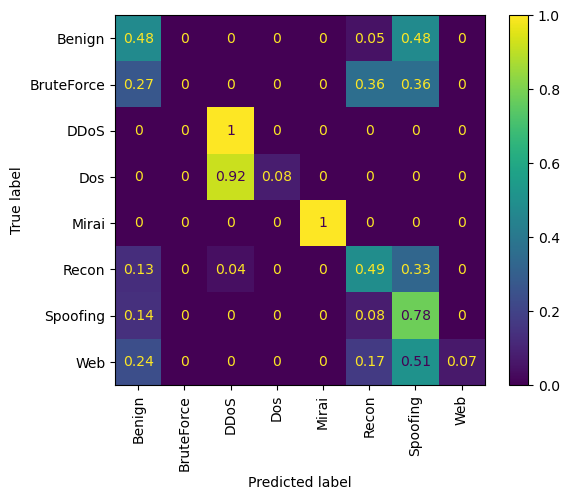

In [17]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100 ,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest")
save_model(rfc, "Random Forest", 8)

              precision    recall  f1-score   support

      Benign      0.775     0.486     0.597      1876
  BruteForce      1.000     0.091     0.167        22
        DDoS      0.819     1.000     0.900     58255
         DoS      0.992     0.072     0.134     13813
       Mirai      0.999     0.994     0.997      4538
       Recon      0.623     0.466     0.533       609
    Spoofing      0.370     0.766     0.499       846
         Web      1.000     0.146     0.255        41

    accuracy                          0.820     80000
   macro avg      0.822     0.503     0.510     80000
weighted avg      0.852     0.820     0.759     80000

Model 'Random Forest - Weight' saved for 8-class classification at: saved_models/class_8/random_forest_-_weight.pkl


<Figure size 1200x600 with 0 Axes>

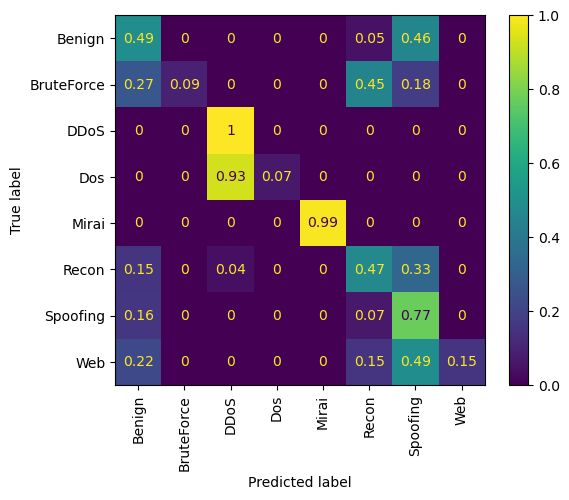

In [18]:
# Weight-balanced
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced",n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest - Weight")
save_model(rfc, "Random Forest - Weight", 8)

/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

              precision    recall  f1-score   support

      Benign      0.821     0.367     0.507      1876
  BruteForce      0.024     0.364     0.045        22
        DDoS      0.842     0.984     0.908     58255
         DoS      0.837     0.206     0.330     13813
       Mirai      0.998     0.989     0.994      4538
       Recon      0.359     0.488     0.413       609
    Spoofing      0.370     0.676     0.479       846
         Web      0.050     0.610     0.093        41

    accuracy                          0.828     80000
   macro avg      0.538     0.585     0.471     80000
weighted avg      0.840     0.828     0.794     80000

Model 'Random Forest - Bagging' saved for 8-class classification at: saved_models/class_8/random_forest_-_bagging.pkl


<Figure size 1200x600 with 0 Axes>

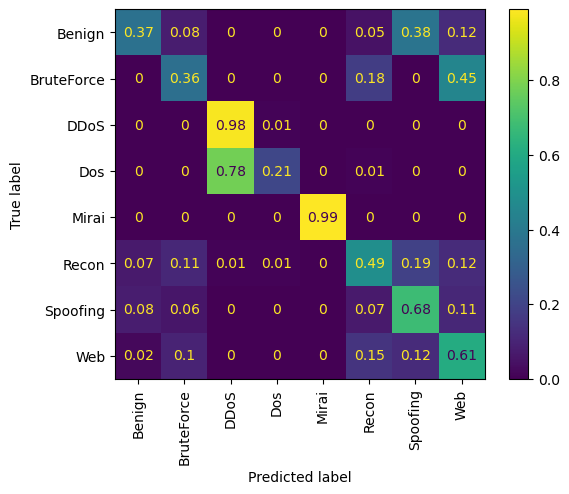

In [19]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True ,n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 8, "Random Forest - Bagging")
save_model(rfc, "Random Forest - Bagging", 8)

In [20]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv('metrics_8.csv', index=True)
metrics_8

,Logistic Regression,Adaboost,Gradientboost,KNN,BSVM,WSVM,XGBoost,Random Forest,Random Forest - Weight,Random Forest - Bagging
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN,0.814638,0.821125,0.819837,0.828063
Recall,NaN,NaN,NaN,NaN,NaN,NaN,0.487389,0.487687,0.502599,0.58535
Precision,NaN,NaN,NaN,NaN,NaN,NaN,0.563179,0.703217,0.82222,0.537714
F1-Score,NaN,NaN,NaN,NaN,NaN,NaN,0.466689,0.479319,0.51027,0.471013


# 34 Classes

In [21]:
scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df34")

In [22]:
weight_dict = get_weights(y_train)
weight_dict

{'DDoS-ICMP_Flood': 1.0,
 'DDoS-UDP_Flood': 1.3327485222273208,
 'DDoS-TCP_Flood': 1.6057560975609746,
 'DDoS-PSHACK_Flood': 1.7570010319182976,
 'DDoS-SYN_Flood': 1.7736628470850218,
 'DDoS-RSTFINFlood': 1.7863680764082344,
 'DDoS-SynonymousIP_Flood': 1.9886825889081294,
 'DoS-UDP_Flood': 2.1790379523389207,
 'DoS-TCP_Flood': 2.6990816661200356,
 'DoS-SYN_Flood': 3.578302775563443,
 'BenignTraffic': 6.580967612954817,
 'Mirai-greeth_flood': 7.218859649122804,
 'Mirai-udpplain': 7.982056256062071,
 'Mirai-greip_flood': 9.630778232884722,
 'DDoS-ICMP_Fragmentation': 15.928064516129023,
 'MITM-ArpSpoofing': 23.291037735849052,
 'DDoS-UDP_Fragmentation': 24.299704724409448,
 'DDoS-ACK_Fragmentation': 25.452061855670088,
 'DNS_Spoofing': 39.03320158102764,
 'Recon-HostDiscovery': 52.58466453674118,
 'Recon-OSScan': 73.04289940828397,
 'Recon-PortScan': 87.85943060498215,
 'DoS-HTTP_Flood': 98.95190380761521,
 'VulnerabilityScan': 201.5387755102039,
 'DDoS-HTTP_Flood': 259.87894736842094,
 

In [23]:
y_test.value_counts()

label
DDoS-ICMP_Flood            12344
DDoS-UDP_Flood              9262
DDoS-TCP_Flood              7687
DDoS-PSHACK_Flood           7026
DDoS-SYN_Flood              6960
DDoS-RSTFINFlood            6910
DDoS-SynonymousIP_Flood     6207
DoS-UDP_Flood               5665
DoS-TCP_Flood               4574
DoS-SYN_Flood               3450
BenignTraffic               1875
Mirai-greeth_flood          1710
Mirai-udpplain              1546
Mirai-greip_flood           1282
DDoS-ICMP_Fragmentation      775
MITM-ArpSpoofing             530
DDoS-UDP_Fragmentation       508
DDoS-ACK_Fragmentation       485
DNS_Spoofing                 316
Recon-HostDiscovery          235
Recon-OSScan                 169
Recon-PortScan               140
DoS-HTTP_Flood               125
VulnerabilityScan             61
DDoS-HTTP_Flood               48
DDoS-SlowLoris                43
DictionaryBruteForce          22
BrowserHijacking              11
SqlInjection                  10
CommandInjection               9
XSS 

In [24]:
# essential for XGBoost
target_names = list(y_test.unique())

## Logistic Regression

In [40]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42, n_jobs=-1)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, y_test, target_names, 34, "Logistic Regression")
save_model(logreg_model, "Logistic Regression", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.658     0.939     0.774      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.829     0.140     0.240       485
        DDoS-HTTP_Flood      0.380     0.396     0.388        48
        DDoS-ICMP_Flood      0.972     0.996     0.984     12344
DDoS-ICMP_Fragmentation      0.622     0.985     0.762       775
      DDoS-PSHACK_Flood      0.999     0.981     0.990      7026
       DDoS-RSTFINFlood      0.999     0.999     0.999      6910
         DDoS-SYN_Flood      0.648     0.969     0.777      6960
         DDoS-SlowLoris      0.438     0.163     0.237        43
DDoS-SynonymousIP_Flood      0.747     0.680     0.712      6207
         DDoS-TCP_Flood      0.612     0.946     0.743      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Adaboost

In [42]:
clf = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=42 )
clf.fit(scaled_X_train, y_train)

evaluate(clf, y_test, target_names, 34, "Adaboost")
save_model(clf, "Adaboost", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.529     0.927     0.673      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.379     0.885     0.531       485
        DDoS-HTTP_Flood      0.000     0.000     0.000        48
        DDoS-ICMP_Flood      0.974     0.992     0.983     12344
DDoS-ICMP_Fragmentation      0.323     0.013     0.025       775
      DDoS-PSHACK_Flood      0.998     0.981     0.989      7026
       DDoS-RSTFINFlood      0.998     0.997     0.997      6910
         DDoS-SYN_Flood      0.661     0.962     0.783      6960
         DDoS-SlowLoris      0.000     0.000     0.000        43
DDoS-SynonymousIP_Flood      0.953     0.999     0.975      6207
         DDoS-TCP_Flood      0.603     0.938     0.734      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gradientboost

In [44]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate = 1, max_depth = None)
gbc.fit(scaled_X_train, y_train)

evaluate(gbc, y_test, target_names, 34, "Gradientboost")
save_model(gbc, "Gradientboost", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.143     0.500     0.222         4
          BenignTraffic      0.826     0.362     0.504      1875
       BrowserHijacking      0.029     0.727     0.055        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.967     0.965     0.966       485
        DDoS-HTTP_Flood      0.333     0.250     0.286        48
        DDoS-ICMP_Flood      0.995     0.997     0.996     12344
DDoS-ICMP_Fragmentation      0.996     0.973     0.984       775
      DDoS-PSHACK_Flood      0.991     1.000     0.996      7026
       DDoS-RSTFINFlood      0.997     0.999     0.998      6910
         DDoS-SYN_Flood      0.569     0.941     0.709      6960
         DDoS-SlowLoris      0.121     0.093     0.105        43
DDoS-SynonymousIP_Flood      0.017     0.001     0.003      6207
         DDoS-TCP_Flood      0.448     0.744     0.559      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## KNN

In [45]:
knn = KNeighborsClassifier(n_neighbors = 8, n_jobs=-1)
knn.fit(scaled_X_train, y_train)

evaluate(knn, y_test, target_names, 34, "KNN")
save_model(knn, "KNN", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.718     0.954     0.820      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.699     0.633     0.665       485
        DDoS-HTTP_Flood      0.650     0.542     0.591        48
        DDoS-ICMP_Flood      0.988     0.992     0.990     12344
DDoS-ICMP_Fragmentation      0.739     0.853     0.792       775
      DDoS-PSHACK_Flood      1.000     0.995     0.998      7026
       DDoS-RSTFINFlood      0.999     0.999     0.999      6910
         DDoS-SYN_Flood      0.900     0.967     0.932      6960
         DDoS-SlowLoris      0.605     0.535     0.568        43
DDoS-SynonymousIP_Flood      0.959     0.947     0.953      6207
         DDoS-TCP_Flood      0.927     0.967     0.947      7687
         DDoS-UDP_Flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Balanced SVM

In [ ]:
# Balanced Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = "balanced", gamma = "scale" )
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 34, "BSVM")
save_model(svc, "BSVM", 34)

## Weighted SVM

In [ ]:
# Weighted Support Vector Machines
svc = SVC(C=1, kernel = "rbf", class_weight = weight_dict, gamma = "scale")
svc.fit(scaled_X_train, y_train)

evaluate(svc, y_test, target_names, 34, "WSVM")
save_model(svc, "WSVM", 34)

## XGBoost

In [46]:
xgc = xgb.XGBClassifier(n_estimators=100, learning_rate = 1, booster = "gbtree", random_state = 42,
                       max_depth = 13, max_samples = 0.9 , n_jobs=-1)
xgc.fit(scaled_X_train, encoded_y_train)

evaluate(xgc, encoded_y_test, target_names, 34, "XGBoost")
save_model(xgc, "XGBoost", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:40:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_samples" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                         precision    recall  f1-score   support

       DDoS-RSTFINFlood      0.000     0.000     0.000         4
         DDoS-UDP_Flood      0.846     0.809     0.827      1875
        DDoS-ICMP_Flood      0.053     0.091     0.067        11
         DDoS-TCP_Flood      0.077     0.111     0.091         9
DDoS-SynonymousIP_Flood      0.086     0.975     0.159       485
          DoS-SYN_Flood      0.580     0.604     0.592        48
     Mirai-greeth_flood      0.996     0.994     0.995     12344
      DDoS-PSHACK_Flood      0.987     0.968     0.977       775
         DDoS-SYN_Flood      0.930     0.999     0.963      7026
 DDoS-UDP_Fragmentation      0.999     0.198     0.330      6910
          BenignTraffic      0.967     0.905     0.935      6960
          DoS-TCP_Flood      0.429     0.070     0.120        43
          DoS-UDP_Flood      0.988     0.998     0.993      6207
 DDoS-ACK_Fragmentation      0.931     0.742     0.826      7687
      Mirai-greip_flood 

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

## Random Forest

In [47]:
# Base RF
rfc = RandomForestClassifier(n_estimators=100 , n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest")

save_model(rfc, "Random Forest", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.841     0.924     0.881      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.000     0.000     0.000         9
 DDoS-ACK_Fragmentation      0.990     0.984     0.987       485
        DDoS-HTTP_Flood      0.860     0.896     0.878        48
        DDoS-ICMP_Flood      1.000     0.998     0.999     12344
DDoS-ICMP_Fragmentation      0.986     0.991     0.988       775
      DDoS-PSHACK_Flood      0.999     1.000     1.000      7026
       DDoS-RSTFINFlood      1.000     0.999     1.000      6910
         DDoS-SYN_Flood      0.997     0.999     0.998      6960
         DDoS-SlowLoris      0.925     0.860     0.892        43
DDoS-SynonymousIP_Flood      0.999     0.999     0.999      6207
         DDoS-TCP_Flood      0.999     0.995     0.997      7687
         DDoS-UDP_Flood 

In [48]:
# Weight-balanced
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced" , n_jobs=-1)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest - Weight")
save_model(rfc, "Random Forest - Weight", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

                         precision    recall  f1-score   support

       Backdoor_Malware      0.000     0.000     0.000         4
          BenignTraffic      0.765     0.986     0.862      1875
       BrowserHijacking      0.000     0.000     0.000        11
       CommandInjection      0.667     0.222     0.333         9
 DDoS-ACK_Fragmentation      1.000     0.977     0.989       485
        DDoS-HTTP_Flood      0.851     0.833     0.842        48
        DDoS-ICMP_Flood      1.000     0.997     0.999     12344
DDoS-ICMP_Fragmentation      0.991     0.990     0.990       775
      DDoS-PSHACK_Flood      1.000     0.999     1.000      7026
       DDoS-RSTFINFlood      1.000     1.000     1.000      6910
         DDoS-SYN_Flood      0.998     0.998     0.998      6960
         DDoS-SlowLoris      0.903     0.651     0.757        43
DDoS-SynonymousIP_Flood      0.999     0.998     0.999      6207
         DDoS-TCP_Flood      0.999     0.996     0.998      7687
         DDoS-UDP_Flood 

In [49]:
# Bagging-balanced
rfc = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, y_test, target_names, 34, "Random Forest - Bagging")
save_model(rfc, "Random Forest - Bagging", 34)

/home/faissalm/anaconda3/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to '

                         precision    recall  f1-score   support

       Backdoor_Malware      0.008     0.250     0.015         4
          BenignTraffic      0.749     0.570     0.647      1875
       BrowserHijacking      0.008     0.091     0.015        11
       CommandInjection      0.015     0.111     0.027         9
 DDoS-ACK_Fragmentation      0.684     0.953     0.797       485
        DDoS-HTTP_Flood      0.090     0.625     0.157        48
        DDoS-ICMP_Flood      0.975     0.987     0.981     12344
DDoS-ICMP_Fragmentation      0.995     0.812     0.894       775
      DDoS-PSHACK_Flood      0.997     0.981     0.989      7026
       DDoS-RSTFINFlood      0.999     0.998     0.998      6910
         DDoS-SYN_Flood      0.998     0.740     0.850      6960
         DDoS-SlowLoris      0.150     0.419     0.221        43
DDoS-SynonymousIP_Flood      0.886     0.998     0.939      6207
         DDoS-TCP_Flood      0.984     0.937     0.960      7687
         DDoS-UDP_Flood 

In [68]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv('metrics_34.csv', index=True)
metrics_34

,Logistic Regression,Adaboost,Gradientboost,KNN,BSVM,WSVM,XGBoost,Random Forest,Random Forest - Weight,Random Forest - Bagging
Accuracy,0.780613,0.76475,0.726,0.930737,NaN,NaN,0.8445,0.979487,0.978988,0.884038
Recall,0.415278,0.322925,0.47636,0.572645,NaN,NaN,0.585437,0.657673,0.646246,0.578411
Precision,0.505966,0.309973,0.471793,0.632409,NaN,NaN,0.589831,0.672552,0.692637,0.524111
F1-Score,0.412598,0.283398,0.425473,0.586498,NaN,NaN,0.555677,0.660346,0.657596,0.495294


# Metric Plot

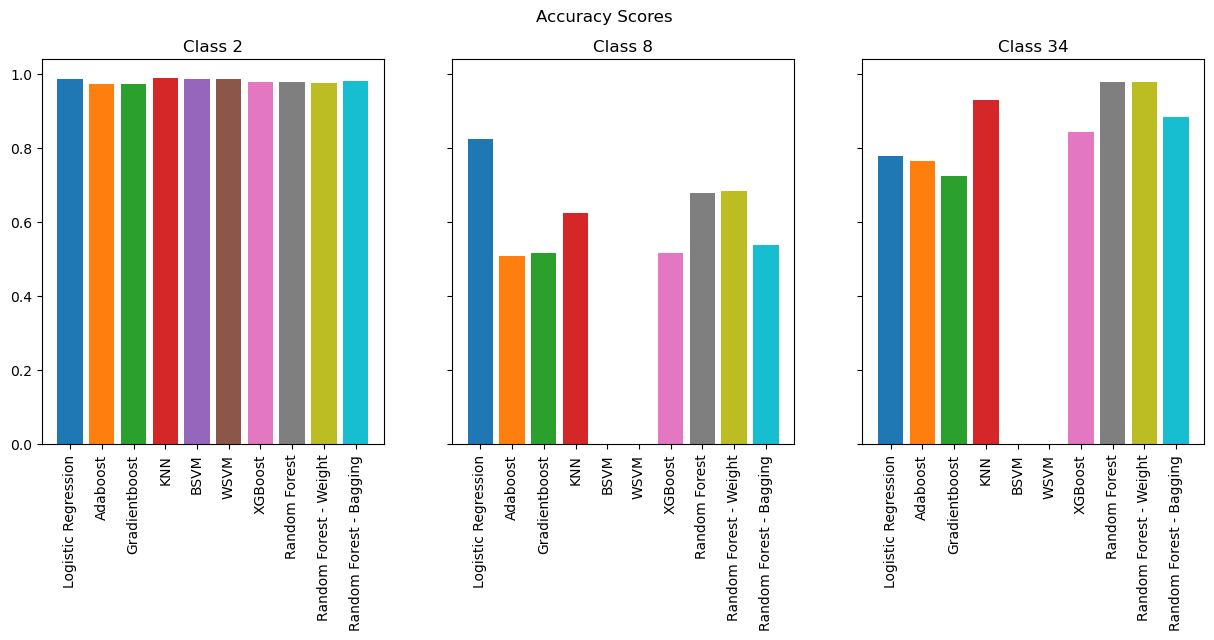

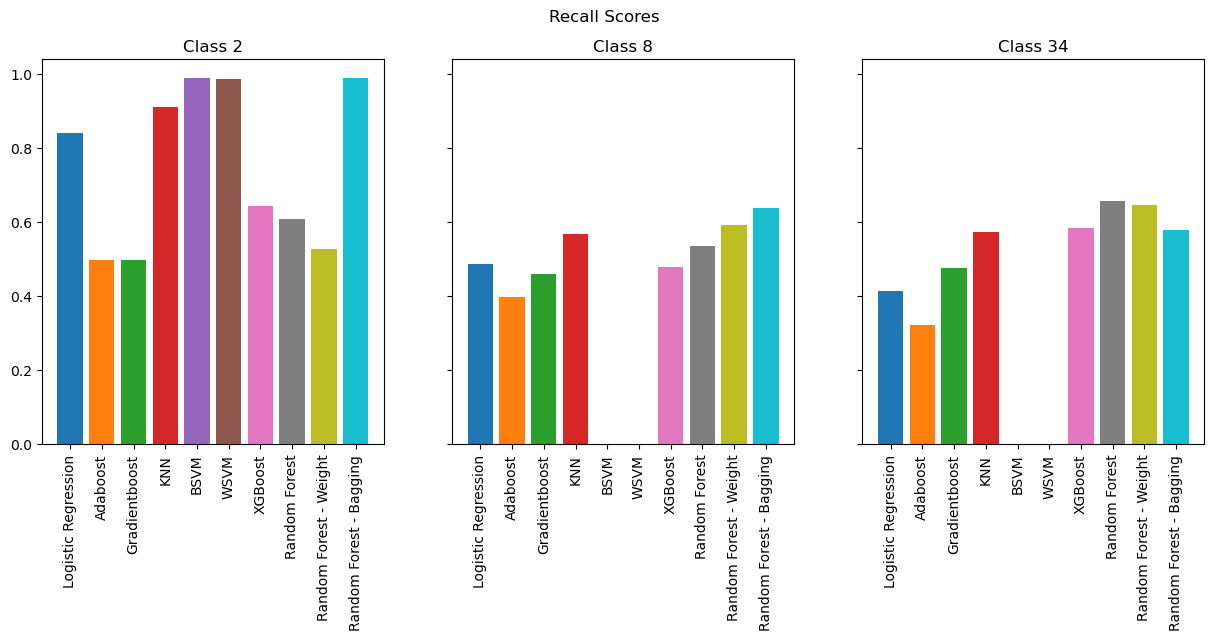

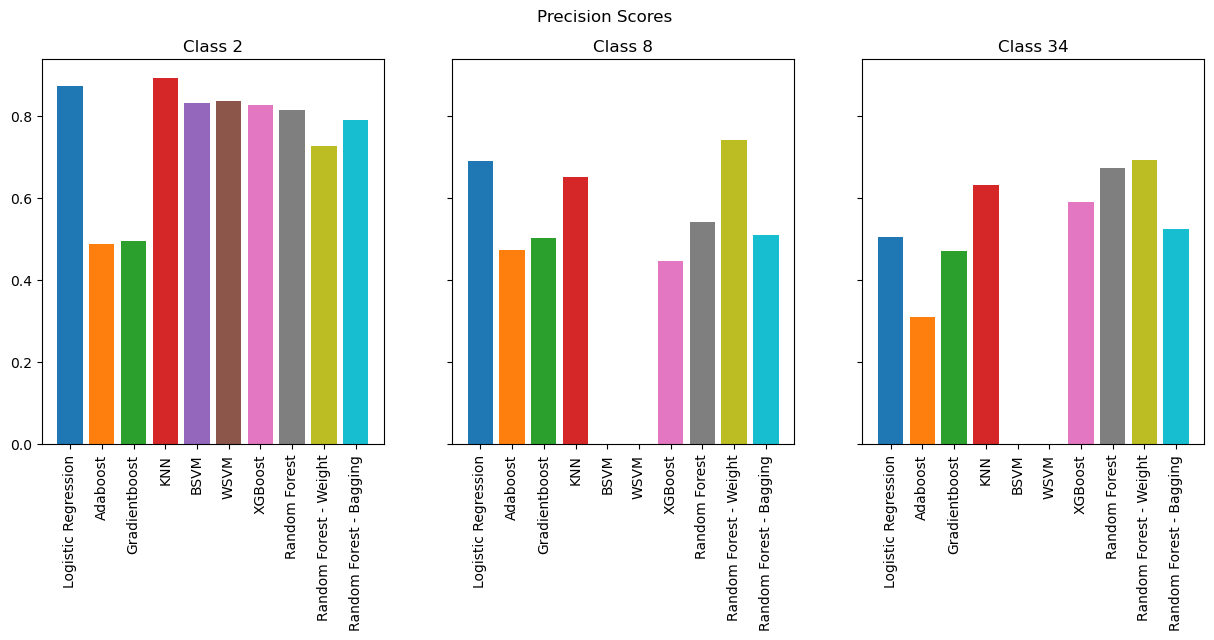

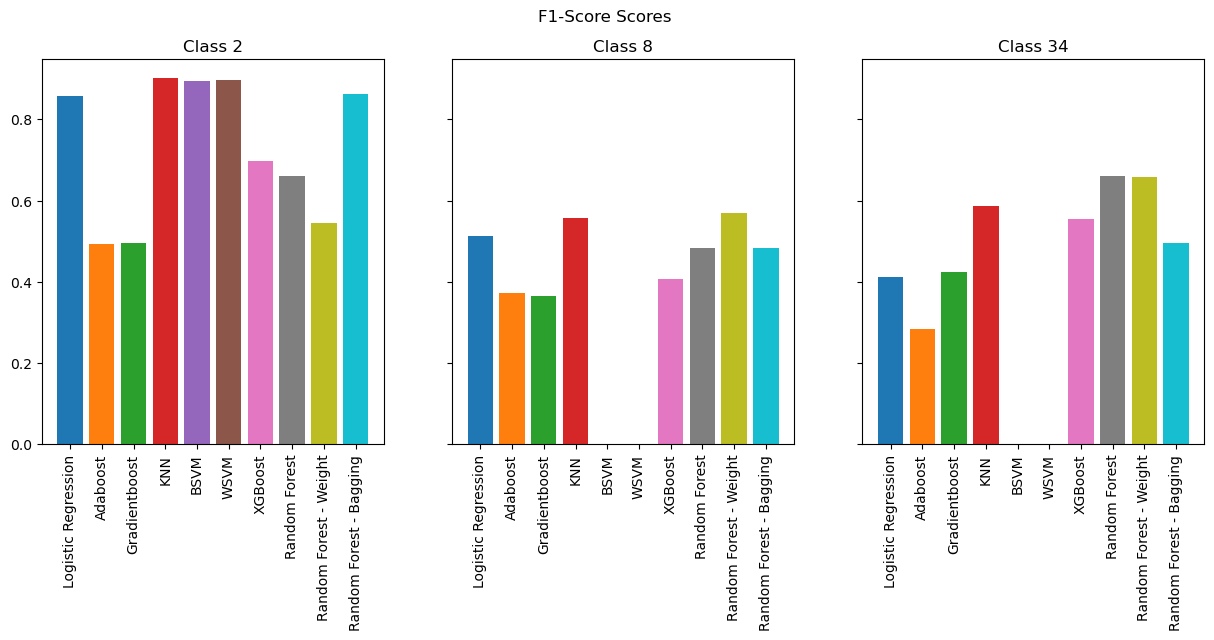

In [69]:
# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "Adaboost": 'tab:orange',
    "Gradientboost": 'tab:green',
    "KNN": 'tab:red',
    "BSVM": 'tab:purple',
    "WSVM": 'tab:brown',
    "XGBoost": 'tab:pink',
    "Random Forest": 'tab:gray',
    "Random Forest - Weight": 'tab:olive',
    "Random Forest - Bagging": 'tab:cyan'
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(15, 5), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")

        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)

        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=90)

    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')

    plt.show()




# Metric Table

In [70]:
# Concatenate them along rows
concatenated_data = pd.concat([metrics_2, metrics_8, metrics_34], ignore_index=False)

# List of model names
model_names = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging"]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a DataFrame with the concatenated data
result_df = pd.DataFrame(concatenated_data.values,
                          pd.MultiIndex.from_product([["2 classes", "8 classes", "34 classes"], metrics]),
                          columns=model_names)

# Display the result
result_df


Logistic Regression  Adaboost Gradientboost       KNN  \
2 classes  Accuracy             0.987425  0.974862        0.9737   0.99085   
           Recall               0.840348  0.499136      0.499321  0.912075   
           Precision            0.873879  0.488255       0.49467  0.893275   
           F1-Score             0.856282  0.493636      0.494759  0.902443   
8 classes  Accuracy             0.824825  0.508425      0.516038    0.6245   
           Recall               0.486738  0.397551      0.460406  0.567513   
           Precision            0.691286  0.473928      0.503558  0.650979   
           F1-Score             0.513877  0.372936      0.364118  0.556995   
34 classes Accuracy             0.780613   0.76475         0.726  0.930737   
           Recall               0.415278  0.322925       0.47636  0.572645   
           Precision            0.505966  0.309973      0.471793  0.632409   
           F1-Score             0.412598  0.283398      0.425473  0.586498   

                          BSVM      WSVM   XGBoost Random Forest  \
2 classes  Accuracy   0.988062  0.988575  0.979988       0.97895   
           Recall     0.990506  0.986867  0.643788      0.610221   
           Precision  0.832001  0.837785  0.825751      0.815123   
           F1-Score   0.894918  0.897927  0.697659      0.660791   
8 classes  Accuracy        NaN       NaN  0.517587      0.678425   
           Recall          NaN       NaN  0.479416      0.536874   
           Precision       NaN       NaN  0.447122      0.540909   
           F1-Score        NaN       NaN  0.406681      0.483064   
34 classes Accuracy        NaN       NaN    0.8445      0.979487   
           Recall          NaN       NaN  0.585437      0.657673   
           Precision       NaN       NaN  0.589831      0.672552   
           F1-Score        NaN       NaN  0.555677      0.660346   

                     Random Forest - Weight Random Forest - Bagging  
2 classes  Accuracy                0.976425                0.983075  
           Recall                   0.52829                0.990554  
           Precision                0.72796                0.790458  
           F1-Score                0.545834                0.862884  
8 classes  Accuracy                0.683825                0.539625  
           Recall                  0.591579                0.637571  
           Precision               0.740505                0.509603  
           F1-Score                0.569265                0.484013  
34 classes Accuracy                0.978988                0.884038  
           Recall                  0.646246                0.578411  
           Precision               0.692637                0.524111  
           F1-Score                0.657596                0.495294

# Deep nural network

In [39]:
# Ajout des importations nécessaires pour la sauvegarde de modèle
import os
from datetime import datetime

# Fonction pour sauvegarder un modèle après entraînement
def save_model(model, model_name, classes):
    """
    Sauvegarde un modèle Keras après l'entraînement
    
    Parameters:
    -----------
    model : keras.Model
        Le modèle entraîné à sauvegarder
    model_name : str
        Nom du modèle (ex: "DNN")
    classes : int
        Nombre de classes utilisées pour l'entraînement (2, 8 ou 34)
    
    Returns:
    --------
    str
        Chemin où le modèle a été sauvegardé
    """
    # Créer un dossier pour les modèles s'il n'existe pas
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Créer un nom de fichier avec timestamp pour éviter l'écrasement
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Sauvegarder en format H5 (nécessite l'extension .h5)
    h5_path = os.path.join(save_dir, f"{model_name}_{classes}classes_{timestamp}.h5")
    model.save(h5_path)
    print(f"Modèle sauvegardé avec succès au format H5: {h5_path}")
    
    # Sauvegarder en format .keras (nouveau format natif recommandé)
    keras_path = os.path.join(save_dir, f"{model_name}_{classes}classes_{timestamp}.keras")
    model.save(keras_path)
    print(f"Modèle sauvegardé avec succès au format Keras: {keras_path}")
    
    return h5_path, keras_path

In [40]:
# Ajout des importations nécessaires
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

# Configuration pour économiser la mémoire sur système à ressources limitées
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Limiter l'utilisation de la mémoire pour TensorFlow
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)

# Fonction pour créer un modèle DNN adapté aux contraintes système
def create_dnn_model(input_dim, output_dim, hidden_layers=[64, 32], dropout_rate=0.2):
    model = Sequential()
    
    # Première couche cachée
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Couches cachées additionnelles
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Couche de sortie
    if output_dim == 2:
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        model.add(Dense(output_dim, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    
    # Compilation avec optimiseur économe en mémoire
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

# Fonction pour entraîner et évaluer le modèle DNN
def train_evaluate_dnn(X_train, X_test, y_train, y_test, output_dim, class_weights=None, batch_size=32, epochs=30, classes=2, model_name="DNN"):
    input_dim = X_train.shape[1]
    
    # Adapter la taille du modèle selon la complexité du problème
    if classes <= 2:
        hidden_layers = [32, 16]  # Plus petit pour 2 classes
    elif classes <= 8:
        hidden_layers = [64, 32]  # Moyen pour 8 classes
    else:
        hidden_layers = [128, 64, 32]  # Plus grand pour 34 classes
    
    # Réduire la taille des batchs pour les systèmes à faible mémoire
    adjusted_batch_size = min(batch_size, 64)  # Pour s'assurer que ça tient en mémoire
    
    # Créer le modèle
    model = create_dnn_model(input_dim, output_dim, hidden_layers=hidden_layers)
    
    # Callbacks pour optimiser l'entraînement et économiser la mémoire
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
    ]
    
    # Convertir à des arrays numpy pour tensorflow
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train)
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test)
    
    # Entraînement avec validation
    history = model.fit(
        X_train_np, y_train_np,
        epochs=epochs,
        batch_size=adjusted_batch_size,
        validation_split=0.2,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Prédiction
    if output_dim == 2:
        y_pred_prob = model.predict(X_test_np, batch_size=adjusted_batch_size)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(model.predict(X_test_np, batch_size=adjusted_batch_size), axis=1)
    
    # Évaluation
    accuracy = accuracy_score(y_test_np, y_pred)
    recall = recall_score(y_test_np, y_pred, average='macro')
    precision = precision_score(y_test_np, y_pred, average='macro')
    f1 = f1_score(y_test_np, y_pred, average='macro')
    
    # Insérer les métriques dans le dataframe
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])
    
    # Afficher le rapport de classification
    print(classification_report(y_test_np, y_pred, digits=3))
    
    # Afficher la matrice de confusion si applicable
    if classes == 2 or classes == 8:
        plt.figure(figsize=(4, 2), dpi=300)
        target_names = []
        if classes == 2:
            target_names = ["Attack", "Benign"]
        elif classes == 8:
            target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]
            
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test_np, y_pred, normalize="true"), 2),
                               display_labels=target_names).plot()
        plt.xticks(rotation=90)
        
    return model, history

# Exemple d'utilisation pour 2 classes
# Mise à jour des fonctions d'exécution pour sauvegarder les modèles

def run_dnn_2classes():
    print("Exécution du DNN pour 2 classes...")
    scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df2")
    
    # Préparation des poids de classe pour gérer le déséquilibre
    weight_dict = get_weights(y_train)
    
    # Pour la classification binaire
    if 'benign' in y_train.unique():
        # Si les classes sont 0 et 1
        output_dim = 2
        # Créer des poids de classe compatibles avec keras
        class_weights = {i: weight_dict[label] for i, label in enumerate(weight_dict.keys())}
    else:
        # Si les classes sont déjà encodées
        output_dim = 2
        class_weights = weight_dict
    
    # Entraîner et évaluer le modèle DNN
    model_dnn, history = train_evaluate_dnn(
        scaled_X_train, scaled_X_test, 
        encoded_y_train, encoded_y_test,
        output_dim=output_dim,
        class_weights=class_weights,
        batch_size=32, 
        epochs=20,
        classes=2,
        model_name="DNN"
    )
    
    # Sauvegarder le modèle
    save_model(model_dnn, "DNN", 2)
    
    return model_dnn, history

def run_dnn_8classes():
    print("Exécution du DNN pour 8 classes...")
    scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df8")
    
    # Préparation des poids de classe
    weight_dict = get_weights(y_train)
    class_weights = {i: weight_dict[label] for i, label in enumerate(sorted(weight_dict.keys()))}
    
    # Entraîner et évaluer
    model_dnn, history = train_evaluate_dnn(
        scaled_X_train, scaled_X_test, 
        encoded_y_train, encoded_y_test,
        output_dim=8,
        class_weights=class_weights,
        batch_size=32, 
        epochs=25,
        classes=8,
        model_name="DNN"
    )
    
    # Sauvegarder le modèle
    save_model(model_dnn, "DNN", 8)
    
    return model_dnn, history

def run_dnn_34classes():
    print("Exécution du DNN pour 34 classes...")
    scaled_X_train, scaled_X_test, y_train, y_test, encoded_y_train, encoded_y_test = split("df34")
    
    # Préparation des poids de classe
    weight_dict = get_weights(y_train)
    class_weights = {i: weight_dict[label] for i, label in enumerate(sorted(weight_dict.keys()))}
    
    # Entraîner et évaluer avec des paramètres adaptés pour économiser de la mémoire
    model_dnn, history = train_evaluate_dnn(
        scaled_X_train, scaled_X_test, 
        encoded_y_train, encoded_y_test,
        output_dim=34,
        class_weights=class_weights,
        batch_size=16,  # Batch size plus petit pour 34 classes
        epochs=15,      # Moins d'époques pour économiser du temps/mémoire
        classes=34,
        model_name="DNN"
    )
    
    # Sauvegarder le modèle
    save_model(model_dnn, "DNN", 34)
    
    return model_dnn, history
    
# Mettez à jour la liste des colonnes pour inclure DNN
columns = ["Logistic Regression", "Adaboost", "Gradientboost", "KNN", "BSVM", "WSVM", 
           "XGBoost", "Random Forest", "Random Forest - Weight", "Random Forest - Bagging", "DNN"]

# Créer de nouveaux dataframes de métriques avec la colonne DNN
metrics_2 = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1-Score"], columns=columns)
metrics_8 = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1-Score"], columns=columns)
metrics_34 = pd.DataFrame(index=["Accuracy", "Recall", "Precision", "F1-Score"], columns=columns)

# Pour exécuter les modèles DNN sur chaque ensemble de données


Exécution du DNN pour 2 classes...


/home/faissalm/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9097 - loss: 0.3597 - val_accuracy: 0.9793 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 2/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9796 - loss: 0.1184 - val_accuracy: 0.9827 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 3/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9824 - loss: 0.0951 - val_accuracy: 0.9850 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 4/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9819 - loss: 0.0984 - val_accuracy: 0.9846 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 5/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9831 - loss: 0.0921 - val_accuracy: 0.9848 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 6/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9837 - loss: 0.0876 - val_accuracy: 0.9848 - val_loss: 0.0577 - learning_rate: 0.0010
Epoch 7/20
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9

Modèle sauvegardé avec succès au format H5: /home/faissalm/ML ALGO IOT/saved_models/DNN_2classes_20250424_064120.h5
Modèle sauvegardé avec succès au format Keras: /home/faissalm/ML ALGO IOT/saved_models/DNN_2classes_20250424_064120.keras


(<Sequential name=sequential_7, built=True>,
 <keras.src.callbacks.history.History at 0x7f03c30dac90>)

<Figure size 1200x600 with 0 Axes>

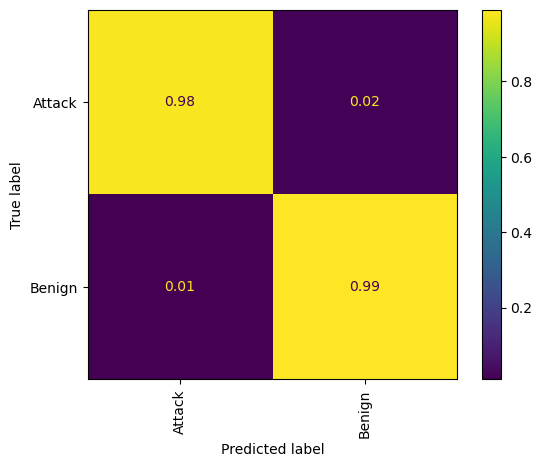

In [41]:
run_dnn_2classes()

Exécution du DNN pour 8 classes...


/home/faissalm/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.3890 - loss: 10.2493 - val_accuracy: 0.6273 - val_loss: 0.6781 - learning_rate: 0.0010
Epoch 2/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6147 - loss: 6.4270 - val_accuracy: 0.6323 - val_loss: 0.6100 - learning_rate: 0.0010
Epoch 3/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.6417 - loss: 5.8462 - val_accuracy: 0.6670 - val_loss: 0.5647 - learning_rate: 0.0010
Epoch 4/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6578 - loss: 5.9999 - val_accuracy: 0.5931 - val_loss: 0.5740 - learning_rate: 0.0010
Epoch 5/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6647 - loss: 5.6012 - val_accuracy: 0.6116 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 6/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.6683 - loss: 5.3090 - val_accuracy: 0.7064 - val_loss: 0.4993 - learning_rate: 0.0010
Epoch 7/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.

Modèle sauvegardé avec succès au format H5: /home/faissalm/ML ALGO IOT/saved_models/DNN_8classes_20250424_064831.h5
Modèle sauvegardé avec succès au format Keras: /home/faissalm/ML ALGO IOT/saved_models/DNN_8classes_20250424_064831.keras


(<Sequential name=sequential_8, built=True>,
 <keras.src.callbacks.history.History at 0x7f04ace94380>)

<Figure size 1200x600 with 0 Axes>

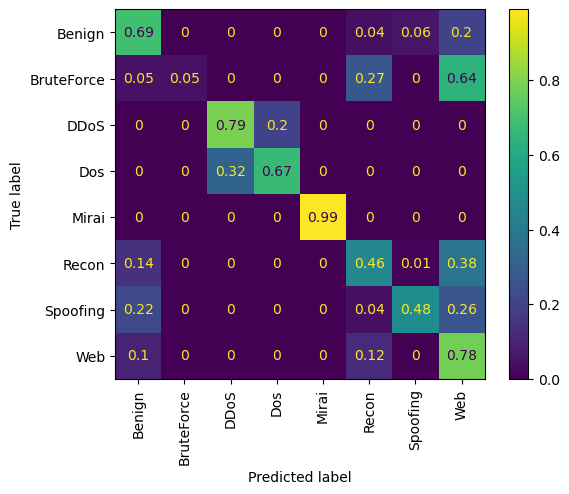

In [42]:
run_dnn_8classes()

In [43]:
run_dnn_34classes()

Exécution du DNN pour 34 classes...


/home/faissalm/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.4486 - loss: 13.7409 - val_accuracy: 0.7105 - val_loss: 0.8105 - learning_rate: 0.0010
Epoch 2/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.6492 - loss: 9.5918 - val_accuracy: 0.6979 - val_loss: 0.6868 - learning_rate: 0.0010
Epoch 3/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.6647 - loss: 9.3779 - val_accuracy: 0.7594 - val_loss: 0.6359 - learning_rate: 0.0010
Epoch 4/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.6734 - loss: 11.3514 - val_accuracy: 0.7090 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 5/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.6870 - loss: 8.1768 - val_accuracy: 0.7106 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 6/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.6838 - loss: 8.7774 - val_accuracy: 0.7158 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 7/15
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step

/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/faissalm/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/f

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         4
           1      0.834     0.414     0.553      1875
           2      0.059     0.091     0.071        11
           3      0.000     0.000     0.000         9
           4      0.375     0.973     0.541       485
           5      0.137     0.729     0.231        48
           6      0.972     0.988     0.980     12344
           7      0.500     0.001     0.003       775
           8      0.999     0.984     0.991      7026
           9      1.000     0.997     0.999      6910
          10      0.645     0.944     0.766      6960
          11      0.312     0.349     0.330        43
          12      0.697     0.544     0.611      6207
          13      0.000     0.000     0.000      7687
          14      0.714     0.974     0.824      9262
          15      0.933     0.955     0.944       508
          16      0.199     0.146     0.168       316
          17      0.000    

(<Sequential name=sequential_9, built=True>,
 <keras.src.callbacks.history.History at 0x7f04acaf4aa0>)

# K-means

In [44]:
# Ajouter ces imports en haut du notebook avec les autres imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import joblib
import os

# Fonction pour créer un dossier de sauvegarde s'il n'existe pas
def create_save_directory(base_dir="saved_models"):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    return base_dir

# Fonction pour sauvegarder un modèle
def save_model(model, model_name, num_classes, base_dir="saved_models"):
    save_dir = create_save_directory(base_dir)
    class_dir = os.path.join(save_dir, f"{num_classes}_classes")
    
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)
        
    model_path = os.path.join(class_dir, f"{model_name}.joblib")
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")
    return model_path

# Fonction pour exécuter K-means et évaluer ses performances
def run_kmeans(X_train, X_test, y_train, y_test, n_clusters, num_classes, save=True):
    # Initialiser et entraîner le modèle K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train)
    
    # Obtenir les prédictions (étiquettes de clusters)
    train_clusters = kmeans.predict(X_train)
    test_clusters = kmeans.predict(X_test)
    
    # Calculer les métriques d'évaluation pour clustering
    try:
        silhouette = silhouette_score(X_test, test_clusters)
        calinski = calinski_harabasz_score(X_test, test_clusters)
        davies = davies_bouldin_score(X_test, test_clusters)
        
        print(f"K-means clustering metrics:")
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski:.3f}")
        print(f"Davies-Bouldin Score: {davies:.3f}")
        
        # Afficher le nombre de points dans chaque cluster
        unique, counts = np.unique(test_clusters, return_counts=True)
        clusters_distribution = dict(zip(unique, counts))
        print("Clusters distribution:", clusters_distribution)
        
        # Visualiser la répartition des classes réelles dans chaque cluster (pour analyse)
        print("\nDistribution of actual classes in clusters:")
        for cluster in range(n_clusters):
            cluster_mask = test_clusters == cluster
            if np.any(cluster_mask):
                cluster_labels = y_test[cluster_mask]
                label_counts = pd.Series(cluster_labels).value_counts()
                print(f"Cluster {cluster}: {label_counts.to_dict()}")
        
        # Sauvegarder le modèle si demandé
        if save:
            model_path = save_model(kmeans, "KMeans", num_classes)
            print(f"K-means model saved for {num_classes} classes")
            
        # Ajouter les métriques au dataframe correspondant
        if num_classes == 2:
            metrics_2.loc['Silhouette', 'K-means'] = silhouette
            metrics_2.loc['Calinski-Harabasz', 'K-means'] = calinski
            metrics_2.loc['Davies-Bouldin', 'K-means'] = davies
        elif num_classes == 8:
            metrics_8.loc['Silhouette', 'K-means'] = silhouette
            metrics_8.loc['Calinski-Harabasz', 'K-means'] = calinski
            metrics_8.loc['Davies-Bouldin', 'K-means'] = davies
        else:
            metrics_34.loc['Silhouette', 'K-means'] = silhouette
            metrics_34.loc['Calinski-Harabasz', 'K-means'] = calinski
            metrics_34.loc['Davies-Bouldin', 'K-means'] = davies
            
    except Exception as e:
        print(f"Error in calculating clustering metrics: {e}")
    
    return kmeans

## 2 Classes

In [ ]:
# Pour la section de 2 classes
# Ajouter après les modèles supervisés et avant metrics_2.to_csv()
print("\n# K-means Clustering")
# Ajoutez les métriques de clustering au DataFrame de métriques
for metric in ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]:
    if metric not in metrics_2.index:
        metrics_2.loc[metric] = None

# Exécuter K-means avec k=2 (pour correspondre au nombre de classes)
kmeans_model_2 = run_kmeans(scaled_X_train, scaled_X_test, y_train, y_test, n_clusters=2, num_classes=2)


## 8 Classes

In [ ]:
# De même pour 8 classes
print("\n# K-means Clustering")
for metric in ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]:
    if metric not in metrics_8.index:
        metrics_8.loc[metric] = None

# Exécuter K-means avec k=8 (pour correspondre au nombre de classes)
kmeans_model_8 = run_kmeans(scaled_X_train, scaled_X_test, y_train, y_test, n_clusters=8, num_classes=8)



## 34 Classes

In [ ]:
# Et pour 34 classes
print("\n# K-means Clustering")
for metric in ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]:
    if metric not in metrics_34.index:
        metrics_34.loc[metric] = None

# Exécuter K-means avec k=34 (pour correspondre au nombre de classes)
kmeans_model_34 = run_kmeans(scaled_X_train, scaled_X_test, y_train, y_test, n_clusters=34, num_classes=34)